In [30]:
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from TJL.data import *
from TJL.utils import *
from TJL.loss import *
from TJL.train import Trainer
from TJL.model import UNet_2DE
import os
import shutil
from skimage.io import imsave

In [31]:
# 将路径下的所有图像改为单通道
def ch3_to_ch1(path):
    f_list = [os.path.join(path,f) for f in os.listdir(path) ]
    for f in f_list:
        img = imread(f)
        if len(img.shape)==3:
            img = img[:,:,0]
            imsave(f,img)






In [32]:
class Edge_Trainer(Trainer):
    def __init__(self, model, optim, loss_func, save_path, device, scheduler=None):
        super().__init__(model, optim, loss_func, save_path, device, scheduler)
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_list = []
        for imgs,label,edge in tqdm(train_loader):
            imgs = imgs.to(self.device)
            label = label.to(self.device)
            edge = edge.to(self.device)

            pred,pred_edge = self.model(imgs)
            loss = self.loss_func(pred,pred_edge,label,edge)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            loss_list.append(loss.item())
        return np.mean(loss_list)

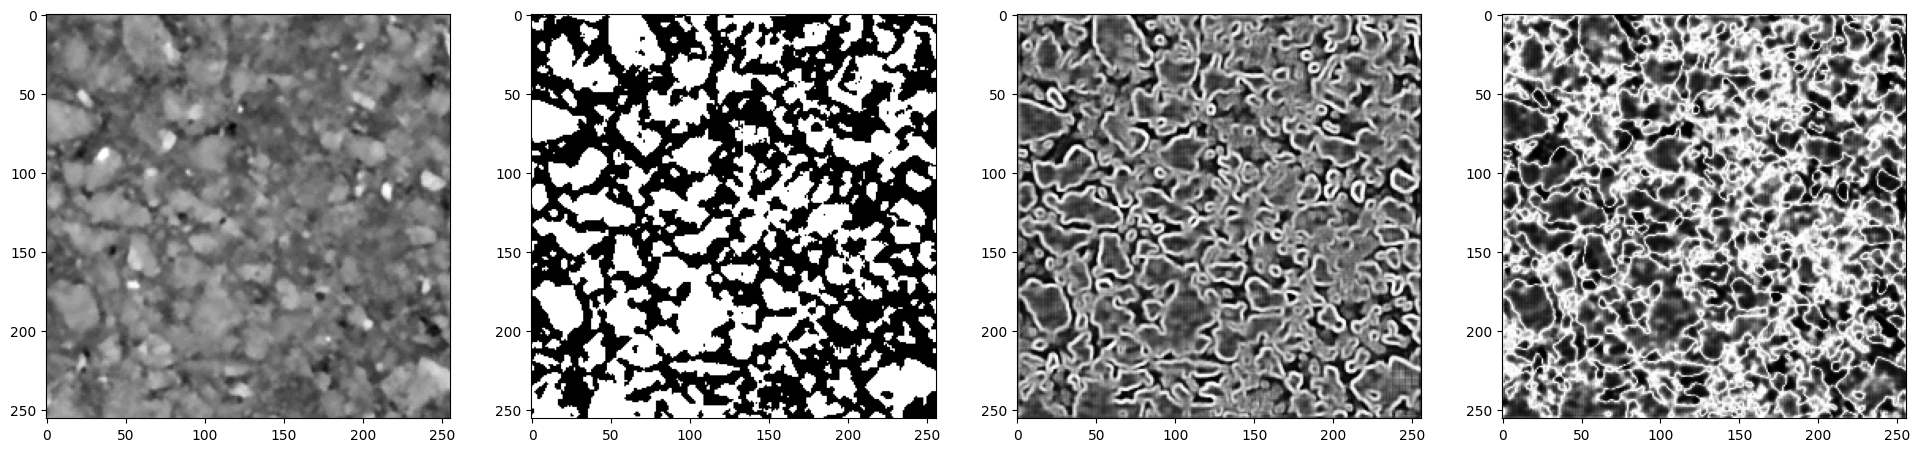

(array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]], dtype=float32),
 array([[0.13074344, 0.26975933, 0.24071603, ..., 0.4071511 , 0.4532272 ,
         0.29505116],
        [0.33000153, 0.5816141 , 0.4288681 , ..., 0.72316474, 0.5664268 ,
         0.41386157],
        [0.3062917 , 0.5569746 , 0.48286116, ..., 0.71726745, 0.43307906,
         0.25740096],
        ...,
        [0.5278026 , 0.74515384, 0.62527627, ..., 0.11588416, 0.09132762,
         0.10502786],
        [0.43358707, 0.5998382 , 0.45442995, ..., 0.1949052 , 0.15941787,
         0.16656588],
        [0.3331938 , 0.39948156, 0.32002348, ..., 0.13848546, 0.17233728,
         0.36273205]], dtype=float32),
 array([[0.91823214, 0.8327443 , 0.8667321 , ..., 0.6543757 , 0.5802736 ,
         0.64569986],
        [0.8188874 , 0.83602107, 0

In [33]:
import time

class AL:
    def __init__(self,
                 model=None,
                 device=None
                 ):
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available else "cpu") if device is None else device
        self.model = model

    def to(self,device:str):
        self.device = torch.device(device)
    
    def load_model(self,path):
        self.model = torch.load(path,map_location=self.device)
    
    def save_model(self,path):
        torch.save(self.model,path)
    

    # 采样
    def get_sample(self,src_path,dst_path,num=50,size=(256,256)):
        src_path = [os.path.join(src_path,f) for f in os.listdir(src_path)]
        for i in tqdm(range(num)):
            img_path = np.random.choice(src_path,1)[0]
            name = os.path.basename(img_path)[:-4]
            img = imread(img_path)
            H,W = img.shape
            h,w = np.random.choice(H-size[0],1)[0],np.random.choice(W-size[1],1)[0]
            img = img[h:h+size[0],w:w+size[1]]
            imsave(os.path.join(dst_path,f"{name}_{h}_{w}.png"),img)
    
    # 训练模型
    def train(self,img_path,mask_path,save_path):
        train_set = ALTrainDataset(img_path,mask_path)
        train_loader = DataLoader(train_set,4)


        device = torch.device("cuda:0"if torch.cuda.is_available()else"cpu")
        optim = torch.optim.Adam(self.model.parameters(),lr=3e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim,T_max=50)
        loss_function = BCELoss()
        trainer = Edge_Trainer(self.model,optim,loss_function,save_path,device,scheduler=scheduler)
        trainer.train_one_epoch(train_loader)
        torch.save(self.model,os.path.join(save_path,"model.pth"))



    # 验证选择需要标记的图像
    def val_select(self,unlabed_path,dst_path,select_num=20):
        select_loader = DataLoader(SelectSet(unlabed_path),1)
        self.model.to(self.device)
        self.model.eval()

        entropy_list = []
        with torch.no_grad():
            for img_path,img in tqdm(select_loader):
                img = img.to(self.device)
                pred,_ = self.model(img)
                pred = pred.cpu().numpy()
                entropy_list.append([img_path[0],self.entropy(pred)])

        entropy_list.sort(key=lambda x:-x[-1])
        for src,_ in entropy_list[:select_num]:
            dst = os.path.join(dst_path,src.split("/")[-1])
            shutil.move(src,dst)
        return entropy_list
    
    # 预测一张图像
    def pred_one_img(self,img_path,thread=0.5,show=True):
        img = min_max_norm(imread(img_path))
        img = hist_clahe(img)
        img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
        img = img.to(self.device)
        self.model.to(self.device)
        self.model.eval()
        with torch.no_grad():
            pred,pred_edge = self.model(img)

        img = img.cpu().numpy()[0,0]
        pred = pred.cpu().numpy()[0,0]
        pred_edge = pred_edge.cpu().numpy()[0,0]
        entropy = min_max_norm(self.entropy(pred,"RAW"))

        pred[pred>thread]=1
        pred[pred<1]=0
        if show:
            imshow([img,pred,pred_edge,entropy])
        return pred,pred_edge,entropy

    # 信息熵
    def entropy(self,x,mod="MEAN"):
        x = (-x*np.log2(x))
        if mod=="MEAN":
            return x.mean()
        elif mod=="SUM":
            return x.sum()
        elif mod=="RAW":
            return x


al = AL()
al.load_model("./model/UNet_2DE_CLAHE/model.pth")
# al.load_model("./model/AL/model.pth")

# 选择
# al.get_sample("./data/AL/pool/","./data/AL/sample/",100)
# al.val_select("./data/AL/sample/","./data/AL/selected/",10)

# 训练
# ch3_to_ch1("./data/AL/selected/")
# al.train("./data/AL/pool/","./data/AL/selected/","./model/AL/")

# 查看
# al.pred_one_img("./data/AL/sample/sub0283_740_871.png")

In [34]:
# al.pred_one_img("./data/AL/sample/sub0293_1007_1146.png")